In [1]:
#include <stdio.h>

__global__ void mykernel()
{
    int threadId = threadIdx.x + threadIdx.y * blockDim.x;

    printf("Hello from device! Thread ID: %d\n", threadId);
}

int main()
{
    // 1个 2*2 的线程块 
    dim3 blockDim(2, 2);
    mykernel<<<1, blockDim>>>();
    cudaDeviceSynchronize();
    return 0;
}

SyntaxError: invalid decimal literal (1000813301.py, line 12)

### 2.2 线程块block 线程块栅格grid
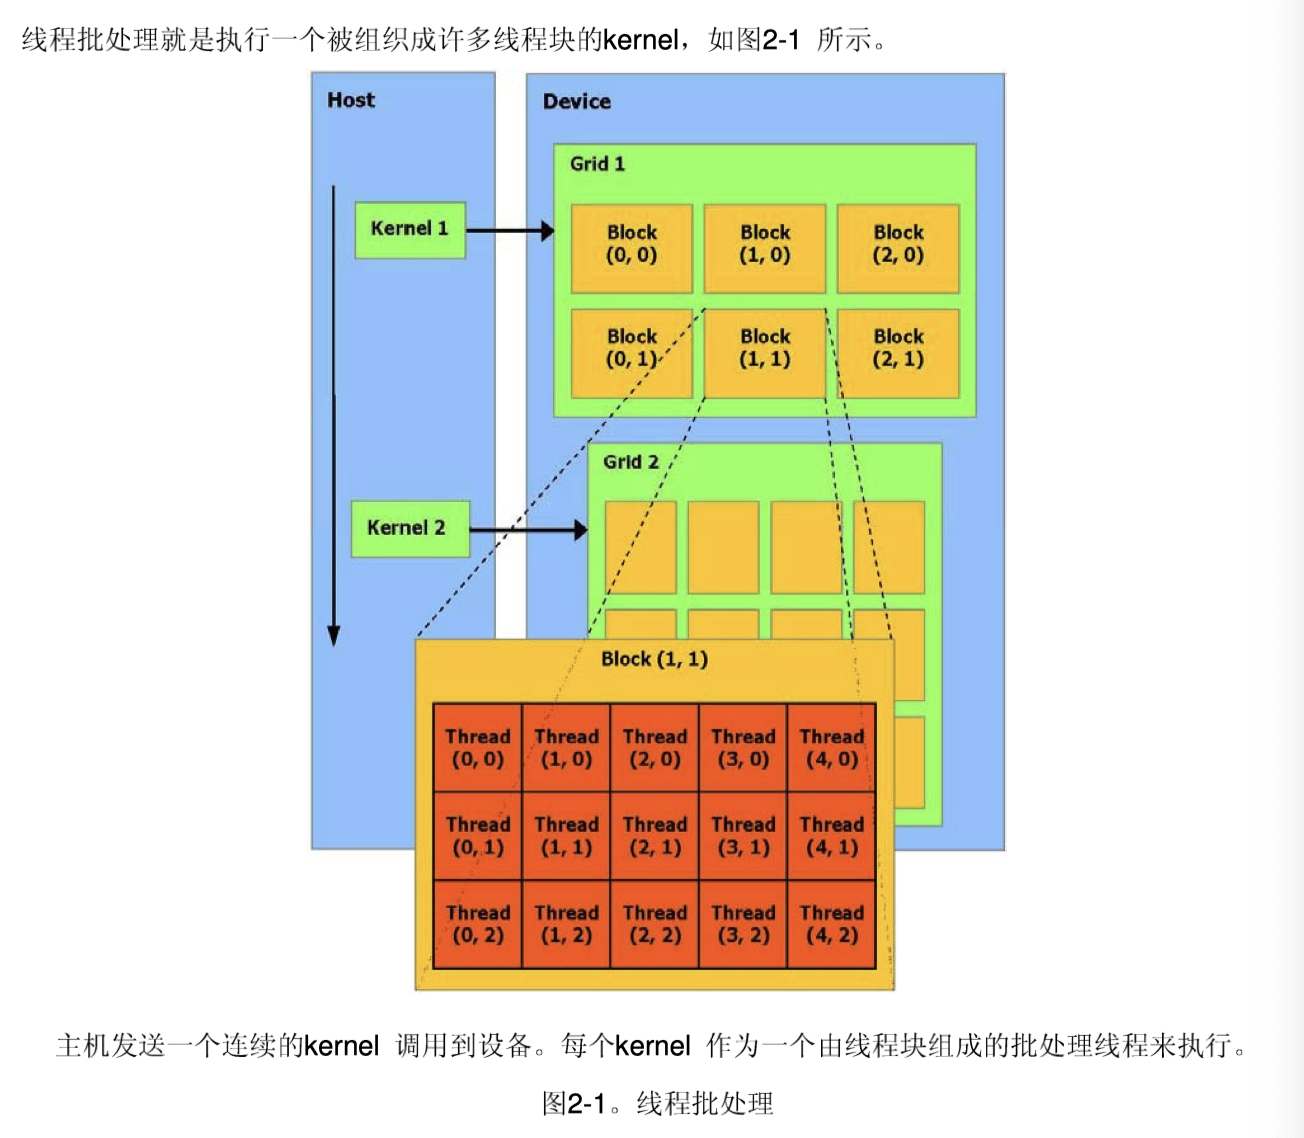

In [ ]:
#include <stdio.h>

__global__ void mykernel()
{
    int blockId = blockIdx.x + blockIdx.y * gridDim.x;
    int threadId = threadIdx.x + threadIdx.y * blockDim.x;

    printf("Hello from device! Block ID: %d, Thread ID: %d\n", blockId, threadId);
}

int main()
{
    // 1个有 4*4 个线程块的网格，每个线程块中有 2*2 个线程
    dim3 blockDim(2, 2);
    dim3 gridDim(4, 4);
    mykernel<<<gridDim, blockDim>>>();
    cudaDeviceSynchronize();
    return 0;
}

### 2.3 内存模型
一条执行在 device 上的 thread，只允许通过如下的内存空间使用 device 的 DRAM 和 On-Chip 内存：
1. 读写每条 thread 的 register
2. 读写每条 thread 的 local memory
3. 读写每个 block  的 shared memory
4. 读写每个 grid   的 global memory
5. 读写每个 grid   的 constant memory
6. 读写每个 grid   的 texture memory


一个在设备上执行的线程只允许通过以下内存空间进行访问：

`寄存器（Registers）`：每个线程都有自己的寄存器，可以用来读取和写入线程的私有数据。寄存器是最快的内存类型，但数量有限。

`本地内存（Local Memory）`：每个线程都有自己的本地内存，可以用来存储线程私有的临时数据。本地内存通常位于设备的全局内存中，访问速度较慢。

`共享内存（Shared Memory）`：每个线程块都有共享内存，可以用来在线程块内的线程之间进行通信和协作。共享内存是一个高带宽、低延迟的内存空间，适合存储线程块共享的数据。

`全局内存（Global Memory）`：每个网格（grid）都有全局内存，所有线程都可以访问。全局内存是设备上最大的内存空间，但访问速度相对较慢。

`常量内存（Constant Memory）`：每个网格都有常量内存，用于存储只读的常量数据。常量内存提供了高速缓存访问，适合存储在内核函数运行时不会改变的数据。

需要注意的是，寄存器、本地内存和共享内存是线程级别的，每个线程都有自己的寄存器和本地内存。而全局内存和常量内存是栅格（grid）级别的，所有线程都可以访问同一份全局内存和常量内存数据。

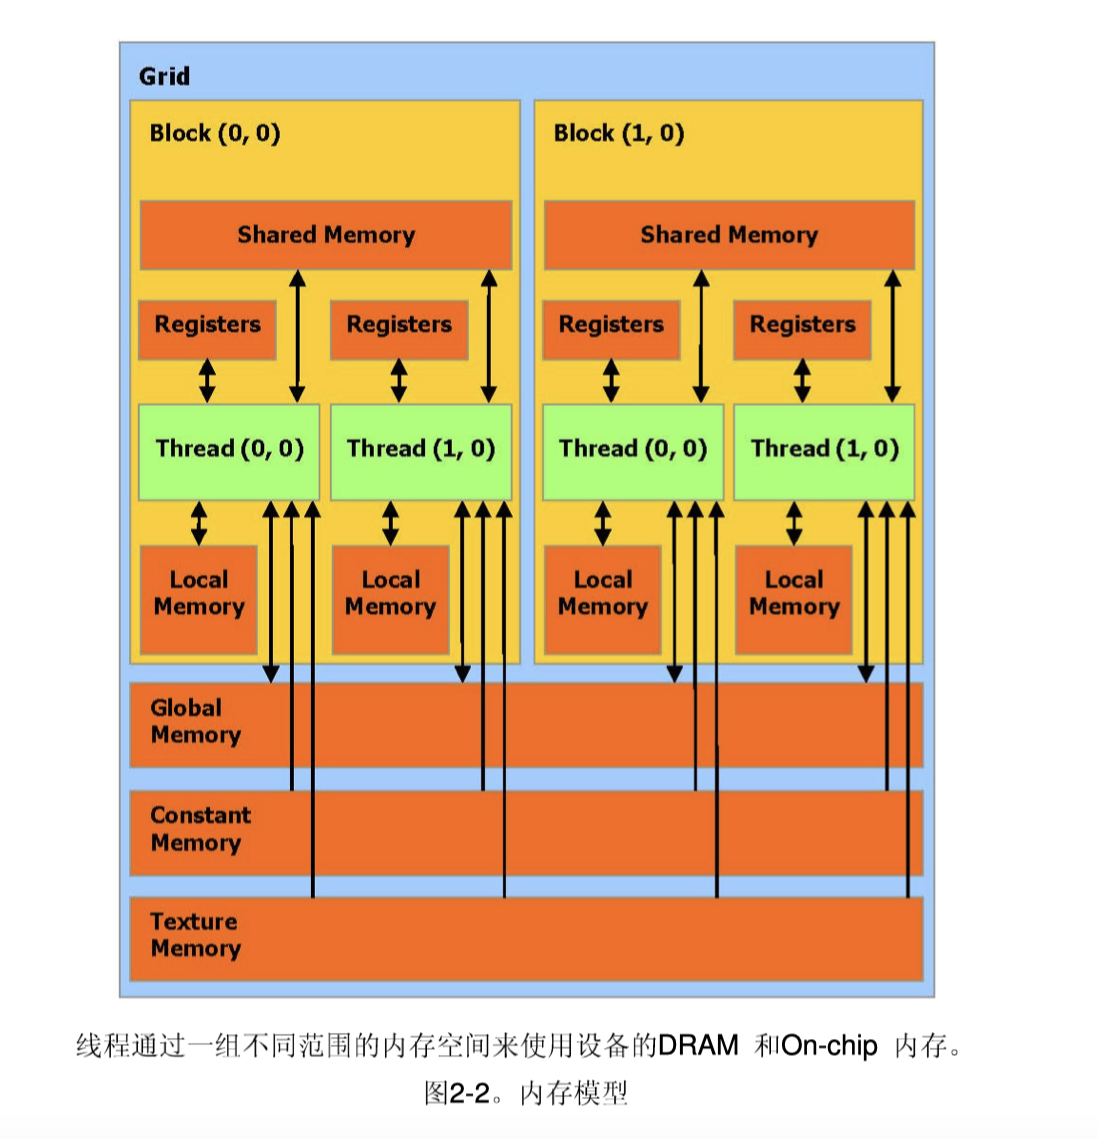

`"on-chip"`通常指的是片上内存（on-chip memory）。片上内存是指位于GPU芯片上的一种高速缓存内存，它位于GPU的多个处理单元（SM）之间。片上内存的目的是提供低延迟和高带宽的内存访问，以满足并行计算的需求。

`L1 Cache（一级缓存）`：L1缓存是一个片上内存层，位于SM和全局内存之间。它用于存储最常用的数据，以提供更快的访问速度。

`Texture Cache（纹理缓存）`：纹理缓存是一种特殊的片上内存，用于高效地存储和访问二维和三维数据。纹理缓存提供了高速缓存访问、坐标插值和过滤等功能，适用于图像处理和纹理映射等应用。

### 3. 硬件实现
一组带有 on-chip 共享内存的 SIMD 多处理器
device 可被看做一组`Multiprocessor`，每个`Multiprocessor`使用单指令多数据架构`SIMD`: 在任何给定的时钟周期内，`Multiprocessor`的每个处理器执行同一指令，但操作不同数据。
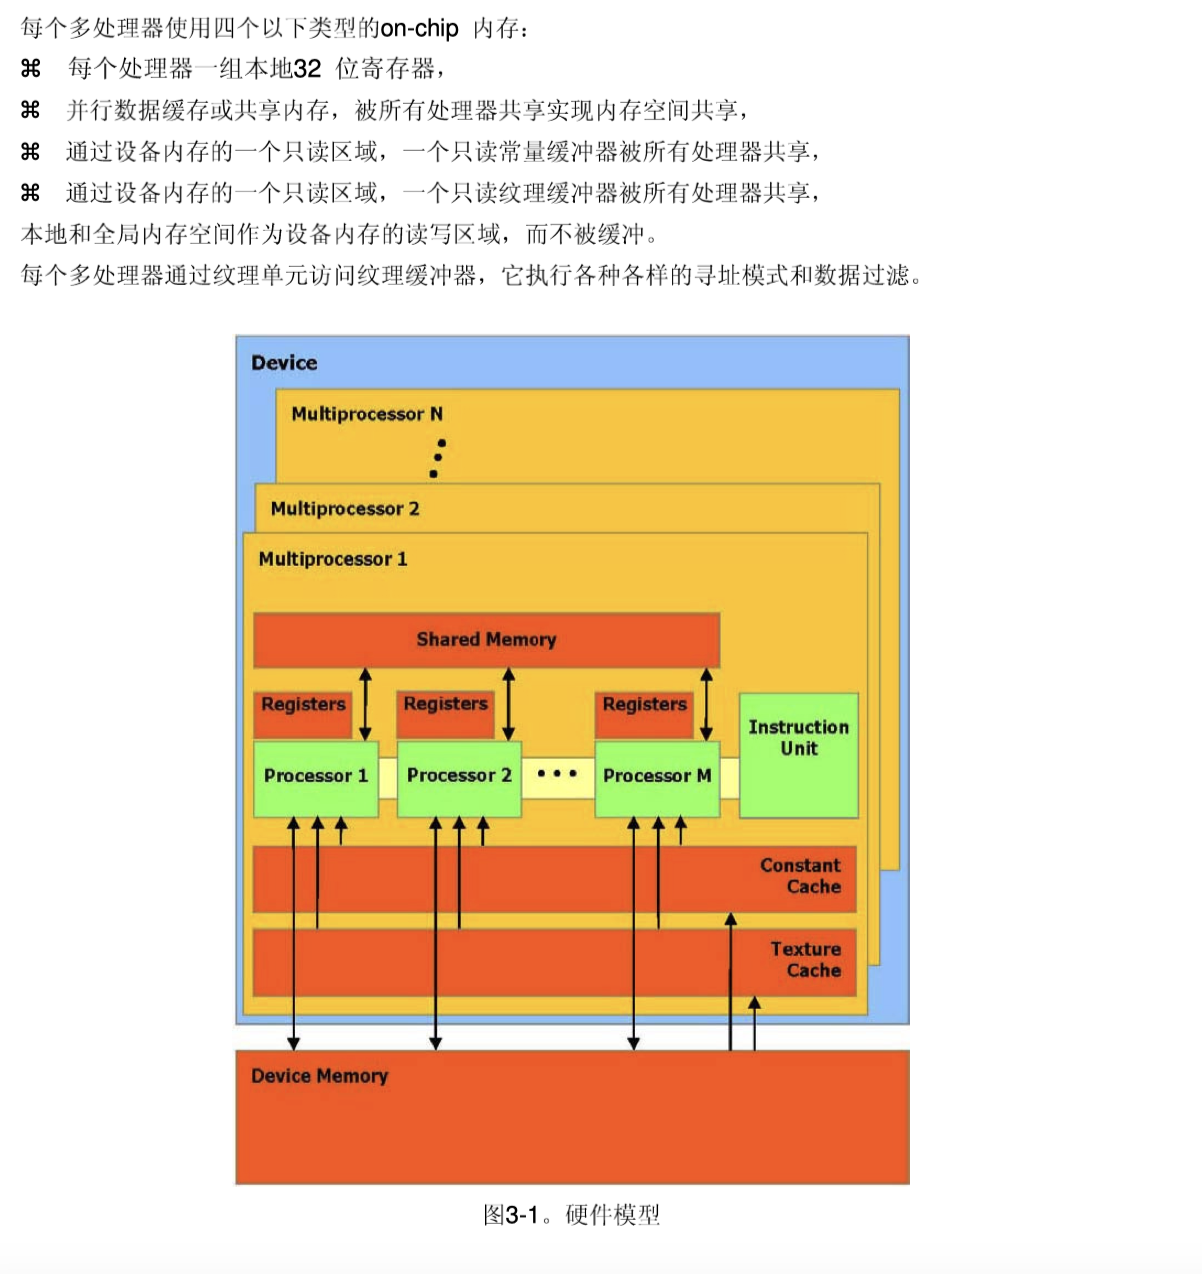

In [ ]:
global void addWithCuda(int *c, int *a, int *b); {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    c[i] = a[i] + b[i];
}

int main() {
// ...
addWithCuda<<<grids, blocks>>>(dev_c, dev_a, dev_b);
// ...
}